<h2><center>NLP -  Logistic Regression & ELMo</center></h2> 

***

### Imports

In [3]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#### Loading Dataset

In [4]:
df_raw = pd.read_csv("hf://datasets/newsmediabias/fake_news_elections_labelled_data/cleaned_fakenewsdata.csv")

In [5]:
df_raw.head(5)

,text,label
0,""""""" Study in journal , Nature Communications :...",REAL
1,""""""" Zelensky told the council that he was ther...",REAL
2,""""""" Central bankers and bureaucrats are seizin...",REAL
3,""""""" Last updated on .From the section Swimming...",REAL
4,THE discussion in the Morning Star and elsewhe...,REAL


#### Pre-processing pipeline

In [6]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sophi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
class NLTKTokenizer():
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.lemmatizer = WordNetLemmatizer()

    def transform(self, X):
        # Tokenization
        return X.apply(self.tokenize)

    def tokenize(self, text):
        # Normalization
        text = re.sub(r'\W', ' ', str(text))  # only alphanumeric characters
        
        tokens = word_tokenize(text.lower())  
        
        # Stopwords 
        filtered_tokens = [t for t in tokens if t not in self.stop_words and t not in string.punctuation]

        # Lemmatization (+ POS-Tagging)
        lemmatized_tokens = [self.lemmatize_with_pos(token, pos) for token, pos in pos_tag(filtered_tokens)]
        
        return ' '.join(lemmatized_tokens)

    def lemmatize_with_pos(self, token, pos):
        # convert NLTK-POS-Tags in WordNet-POS-Tags
        pos = self.get_wordnet_pos(pos)
        return self.lemmatizer.lemmatize(token, pos=pos) if pos else self.lemmatizer.lemmatize(token)

    def get_wordnet_pos(self, nltk_pos):
        # convert NLTK-POS-Tags in WordNet-POS-Tags
        if nltk_pos.startswith('J'):
            return 'a'  # adjectives
        elif nltk_pos.startswith('V'):
            return 'v'  # verbs
        elif nltk_pos.startswith('N'):
            return 'n'  # nouns
        elif nltk_pos.startswith('R'):
            return 'r'  # adverbs
        else:
            return None 


In [8]:
FakeNews = NLTKTokenizer()
df_fakenews = FakeNews.transform(df_raw['text'])

df_fakenews.head()

0    study journal nature communication chain event...
1    zelensky tell council behalf die bucha civilia...
2    central banker bureaucrat seize recent turmoil...
3    last updated section swim fina swim world gove...
4    discussion morning star elsewhere leave approa...
Name: text, dtype: object

Bag-of-words

In [9]:
# # Initialize CountVectorizer for Bag-of-Words
# vectorizer = CountVectorizer()

# # Fit and transform the data
# X_bow = vectorizer.fit_transform(df_fakenews)

# # Vocabulary and feature matrix
# print("Vocabulary:", vectorizer.vocabulary_)
# print("Bag-of-Words Matrix:\n", X_bow.toarray())


tf-idf

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the data
X_tfidf = tfidf_vectorizer.fit_transform(df_fakenews)

# Vocabulary and TF-IDF matrix
print("Vocabulary:", tfidf_vectorizer.vocabulary_)
print("TF-IDF Matrix:\n", X_tfidf.toarray())


Vocabulary: {'study': 50861, 'journal': 28622, 'nature': 36390, 'communication': 11898, 'chain': 10325, 'event': 18848, 'connect': 12291, 'pandemic': 39310, 'shutdown': 48322, 'flood': 20520, 'heat': 24416, 'land': 30520, 'due': 16841, 'aerosol': 2904, 'reduction': 44009, 'also': 3653, 'cool': 12672, 'ocean': 37929, 'gas': 21799, 'intensified': 27295, 'sea': 47159, 'temperature': 52357, 'difference': 15516, 'summer': 51212, 'explain': 19153, 'lead': 30875, 'nanjing': 36230, 'university': 55215, 'information': 26903, 'science': 46987, 'technology': 52247, 'china': 10771, 'turn': 54250, 'south': 49564, 'philippine': 40470, 'intensify': 27297, 'wind': 57894, 'bring': 8508, 'moist': 35165, 'air': 3188, 'eastern': 17157, 'emission': 17856, 'reduce': 44003, 'dramatically': 16628, 'early': 17109, '2020': 758, 'covid': 13107, '19': 580, 'immediate': 26225, 'abrupt': 2305, 'change': 10398, 'various': 56081, 'component': 12004, 'climate': 11317, 'system': 51767, 'would': 58270, 'different': 1551

Labels to binary

In [11]:
df_labels = df_raw
df_labels['label_numeric'] = df_labels['label'].map({'REAL': 1, 'FAKE': 0})

df_label_list = df_labels['label_numeric']

df_label_list.to_list()
df_label_list

0       1
1       1
2       1
3       1
4       1
       ..
9508    1
9509    1
9510    1
9511    1
9512    1
Name: label_numeric, Length: 9513, dtype: int64

Split into train / test

In [12]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_fakenews, df_label_list, test_size=0.2, random_state=42)

Balancing dataset

In [13]:
df_training_set = pd.DataFrame({'text' : X_train, 'label' : y_train})


In [14]:
df_training_set.shape

(7610, 2)

In [15]:
majority = df_training_set[df_training_set['label'] == 1]
minority = df_training_set[df_training_set['label'] == 0]

print(f"Minorities: {minority.shape} \nMajority: {majority.shape}")


# # upsampling

# data_minority_upsampled = resample(minority, 
#                                    replace=True,  
#                                    n_samples=len(majority),  
#                                    random_state=42) 

# print(f"Minority: {data_minority_upsampled.shape}, Majority: {majority.shape}")
# data = pd.concat([majority, data_minority_upsampled])
# data = data.sample(frac=1, random_state=42).reset_index(drop=True)


# downsample Dataset

data_majority_downsampled = resample(majority, 
                                   replace=True,  
                                   n_samples=len(minority),  
                                   random_state=42)

print(f"Minority: {minority.shape}, Majority: {data_majority_downsampled.shape}")
data = pd.concat([minority, data_majority_downsampled])
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

data['label'].value_counts()

Minorities: (2186, 2) 
Majority: (5424, 2)
Minority: (2186, 2), Majority: (2186, 2)


label
0    2186
1    2186
Name: count, dtype: int64

### Logistic Regression

In [16]:
X_train = data['text']
y_train = data['label']

X_train.shape, y_train.shape

((4372,), (4372,))

c:\Users\sophi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[390 147]
 [500 866]]
Accuracy: 66.00%
Classification:               precision    recall  f1-score   support

           0       0.44      0.73      0.55       537
           1       0.85      0.63      0.73      1366

    accuracy                           0.66      1903
   macro avg       0.65      0.68      0.64      1903
weighted avg       0.74      0.66      0.68      1903



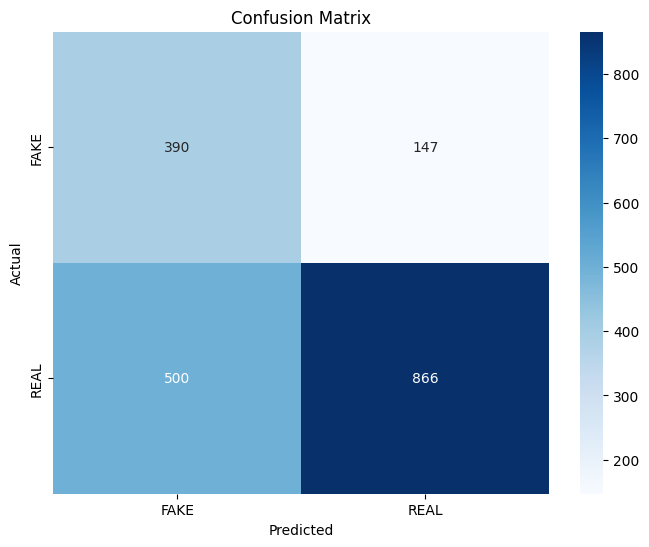

In [17]:
# Convert the text to a bag-of-words representation
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

classification = classification_report(y_test, y_pred)
print(f'Classification: {classification}')


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
print(classification)

              precision    recall  f1-score   support

           0       0.44      0.73      0.55       537
           1       0.85      0.63      0.73      1366

    accuracy                           0.66      1903
   macro avg       0.65      0.68      0.64      1903
weighted avg       0.74      0.66      0.68      1903



In [18]:
# class TextPreprocessor:
#     def __init__(self):
#         self.stop_words = set(stopwords.words('english'))
#         self.lemmatizer = WordNetLemmatizer()


#     def preprocess(self, text):
#         text = re.sub(r'\W', ' ', text)  # Remove non-word characters
#         text = text.lower()  # Convert to lowercase
#         tokens = word_tokenize(text)  # Tokenize text
#         tokens = [t for t in tokens if t not in self.stop_words and t not in string.punctuation]  # Remove stopwords
#         tokens = [self.lemmatizer.lemmatize(t) for t in tokens]  # Lemmatization
#         pos_tags = nltk.pos_tag(tokens)  # POS Tagging
#         return ' '.join([f"{word}/{tag}" for word, tag in pos_tags])

# preprocessor = TextPreprocessor()
# df_training_set1 = df_training_set.copy()
# df_training_set1['processed_news'] = df_training_set1['text'].apply(preprocessor.preprocess)

# # 3. Encode Labels
# # Convert labels (REAL/FAKE) to numeric (1/0)
# df_training_set1['label_numeric'] = df_training_set1['label'].map({'REAL': 1.0, 'FAKE': 0.0})

# # 4. Split Dataset (Two-thirds training, one-third testing)
# X = df_training_set1['processed_news']
# y = df_training_set1['label_numeric']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

# # 5. Bag-of-Words Representation
# vectorizer = CountVectorizer()
# X_train_bow = vectorizer.fit_transform(X_train)
# X_test_bow = vectorizer.transform(X_test)

# # 6. Train Logistic Regression Model
# model = LogisticRegression()
# model.fit(X_train_bow, y_train)

# # 7. Predictions
# y_pred = model.predict(X_test_bow)

# # 8. Evaluation
# print("Classification Report:")
# print(classification_report(y_test, y_pred))

# print("Confusion Matrix:")
# conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)

# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy * 100:.2f}%")


# plt.figure(figsize=(8, 6))
# sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()

***

### ELMo (Embeddings from Language Models)

In [19]:
# ELMo-Modul laden
elmo = hub.load("https://tfhub.dev/google/elmo/3")

# ELMo-Embeddings als TensorFlow-Input-Schicht
def elmo_embedding_layer(texts):
    embeddings = elmo.signatures['default'](tf.constant(texts))['elmo']
    return tf.reduce_mean(embeddings, axis=1)  # Mittelwert der Wort-Embeddings für jeden Text

# Embedding-Funktion erstellen
def embed_texts(texts):
    return elmo_embedding_layer(texts).numpy()

# Embeddings für Trainings- und Testdaten generieren
X_train_embeddings = embed_texts(X_train.tolist())
X_test_embeddings = embed_texts(X_test.tolist())

# TensorFlow-Modell erstellen
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024,)),  # ELMo erzeugt 1024-dimensionale Vektoren
    tf.keras.layers.Dense(256, activation='relu'),  # Versteckte Schicht
    tf.keras.layers.Dropout(0.3),  # Dropout zur Regularisierung
    tf.keras.layers.Dense(1, activation='sigmoid')  # Klassifikation: 1 Neuron mit Sigmoid-Aktivierung
])

# Modell kompilieren
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modell trainieren
history = model.fit(
    X_train_embeddings, y_train,
    validation_data=(X_test_embeddings, y_test),
    epochs=10,
    batch_size=32,
    verbose=1
)

# Modell evaluieren
loss, accuracy = model.evaluate(X_test_embeddings, y_test, verbose=0)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

AttributeError: 'csr_matrix' object has no attribute 'tolist'